In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt

import cv2
from tqdm import tqdm
import io
import seaborn as sns

from sklearn.utils import shuffle # Shuffle arrays or sparse matrices in a consistent way
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.applications.vgg19 import VGG19
import tensorflow as tf
from tensorflow.keras.layers import  Dense, Flatten, Conv2D, Activation, Dropout, MaxPooling2D
from tensorflow.keras import backend as k


from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard,ModelCheckpoint

from sklearn.metrics import classification_report, confusion_matrix
#from tensorflow.keras.utils.vis_utils import plot_model

import ipywidgets as widgets
from PIL import Image
from IPython.display import display, clear_output

In [2]:
labels=['Cu1','Cu2','Cu4','Cu8','Cu16','Cu32','Cu64','Cu128','Cu256','Cu512','Cu1024']

## DataLoading

In [34]:
x_train=[]
y_train=[]

image_size=224

for i in labels:
    folderpath=os.path.join("../input/countingforlaser/Num_Radiation/","new_2^n_train",i)
    
    for j in tqdm(os.listdir(folderpath)):
        image=cv2.imread(os.path.join(folderpath,j))
        image=cv2.resize(image,(image_size,image_size))
            
        x_train.append(image)
        y_train.append(i)
    
    
for i in labels:
    folderpath=os.path.join("../input/countingforlaser/Num_Radiation/","new_2^n_test",i)
    
    for j in tqdm(os.listdir(folderpath)):
        image=cv2.imread(os.path.join(folderpath,j))
        image=cv2.resize(image,(image_size,image_size))
        
        x_train.append(image)
        y_train.append(i)
        
xtrain=np.array(x_train)
ytrain=np.array(y_train)

100%|██████████| 32/32 [00:00<00:00, 308.95it/s]


In [4]:
xtrain.shape

(1936, 224, 224, 3)

In [5]:
ytrain.shape

(1936,)

In [35]:
xtrain,ytrain=shuffle(xtrain,ytrain,random_state=101)

In [36]:
xtrain,xtest,ytrain,ytest=train_test_split(xtrain,ytrain,test_size=0.1,random_state=101)

In [8]:
xtrain.shape

(1742, 224, 224, 3)

In [9]:
ytrain.shape

(1742,)

In [10]:
xtest.shape

(194, 224, 224, 3)

## Convert into to-categorical

In [37]:
ytrain_new=[]
ytest_new=[]

for i in ytrain:
    ytrain_new.append(labels.index(i))
    
ytrain=to_categorical(ytrain_new)

for i in ytest:
    ytest_new.append(labels.index(i))
    
ytest=to_categorical(ytest_new)

In [12]:
ytrain.shape

(1742, 11)

In [13]:
ytest.shape

(194, 11)

In [14]:
Vgg19=VGG19(weights="imagenet",include_top=False,input_shape=(image_size,image_size,3))

2022-11-04 03:26:32.332491: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-04 03:26:32.333810: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-04 03:26:32.708741: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-04 03:26:32.709645: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-04 03:26:32.710454: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

80150528/80134624 [==============================] - 0s 0us/step


In [15]:
model=Vgg19.output
model=tf.keras.layers.Dense (1024,activation='relu')(model)
model=tf.keras.layers.Dense (512,activation='relu')(model)
model=tf.keras.layers.GlobalAveragePooling2D()(model)

model=tf.keras.layers.Dense (256,activation='relu')(model)
model=tf.keras.layers.Dense (128,activation='relu')(model)
model=tf.keras.layers.Dropout(0.3)(model)

model=tf.keras.layers.Dense (11,activation="softmax")(model)
model=tf.keras.models.Model(inputs=Vgg19.input, outputs=model)

In [16]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [17]:
from tensorflow.keras.optimizers import SGD
optimizer = SGD(learning_rate = 1e-4, momentum = 0.9)

model.compile(loss='categorical_crossentropy',
             optimizer=optimizer,
              metrics=['accuracy']
             )

In [18]:
tensorboard=TensorBoard(log_dir="logs")
checkpoint=ModelCheckpoint("Vgg19.h5",
                          monitor='val_accuracy',
                          mode="auto",
                          verbose=1,
                          save_best_only=True
                          )

reduce_LR=ReduceLROnPlateau(monitor='val_accuracy',
                           factor=0.1,
                            patience=10,
                            min_delta=0.001,
                            mode="auto",
                            verbose=1
                           )

2022-11-04 03:28:25.594253: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-11-04 03:28:25.594293: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-11-04 03:28:25.598404: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1614] Profiler found 2 GPUs
2022-11-04 03:28:26.049830: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-11-04 03:28:26.050020: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed


In [19]:
import timeit
start=timeit.default_timer()
history1=model.fit(xtrain,ytrain,
                 validation_split=0.1,
                  epochs=30,
                  verbose=1,
                  batch_size=32,
                  callbacks=[tensorboard, checkpoint,reduce_LR]
                 )
stop=timeit.default_timer()

2022-11-04 03:28:29.282266: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30


2022-11-04 03:28:32.471300: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


 1/49 [..............................] - ETA: 19:42 - loss: 4.6718 - accuracy: 0.1875

2022-11-04 03:28:54.044551: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-11-04 03:28:54.044587: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


 2/49 [>.............................] - ETA: 54s - loss: 4.4584 - accuracy: 0.1250  

2022-11-04 03:28:55.178603: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-11-04 03:28:55.179760: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2022-11-04 03:28:55.362188: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 513 callback api events and 510 activity events. 
2022-11-04 03:28:55.394047: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-11-04 03:28:55.435783: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/train/plugins/profile/2022_11_04_03_28_55

2022-11-04 03:28:55.453358: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_11_04_03_28_55/ecddcb1e852c.trace.json.gz
2022-11-04 03:28:55.508572: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/train/plug

49/49 [==============================] - 62s 777ms/step - loss: 2.4312 - accuracy: 0.1761 - val_loss: 2.0403 - val_accuracy: 0.3086

Epoch 00001: val_accuracy improved from -inf to 0.30857, saving model to Vgg19.h5
Epoch 2/30
49/49 [==============================] - 23s 480ms/step - loss: 1.7253 - accuracy: 0.3682 - val_loss: 1.0109 - val_accuracy: 0.6971

Epoch 00002: val_accuracy improved from 0.30857 to 0.69714, saving model to Vgg19.h5
Epoch 3/30
49/49 [==============================] - 24s 491ms/step - loss: 0.9573 - accuracy: 0.6465 - val_loss: 0.5309 - val_accuracy: 0.8000

Epoch 00003: val_accuracy improved from 0.69714 to 0.80000, saving model to Vgg19.h5
Epoch 4/30
49/49 [==============================] - 25s 508ms/step - loss: 0.5232 - accuracy: 0.7926 - val_loss: 0.3049 - val_accuracy: 0.8629

Epoch 00004: val_accuracy improved from 0.80000 to 0.86286, saving model to Vgg19.h5
Epoch 5/30
49/49 [==============================] - 25s 516ms/step - loss: 0.3720 - accuracy: 0.84

In [20]:
print("Time: ",stop-start)

Time:  803.572936033


In [21]:
pred=model.predict(xtest)
score=model.evaluate(xtest,ytest)

7/7 [==============================] - 1s 128ms/step - loss: 2.6874e-04 - accuracy: 1.0000


In [22]:
pred=np.argmax(pred,axis=1)
ytest=np.argmax(ytest,axis=1)
print(classification_report(ytest,pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        22
           1       1.00      1.00      1.00        13
           2       1.00      1.00      1.00        21
           3       1.00      1.00      1.00        17
           4       1.00      1.00      1.00        19
           5       1.00      1.00      1.00        18
           6       1.00      1.00      1.00        15
           7       1.00      1.00      1.00        19
           8       1.00      1.00      1.00        12
           9       1.00      1.00      1.00        22
          10       1.00      1.00      1.00        16

    accuracy                           1.00       194
   macro avg       1.00      1.00      1.00       194
weighted avg       1.00      1.00      1.00       194



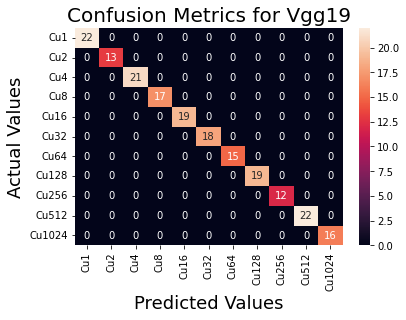

In [23]:
Cm=confusion_matrix(ytest,pred)
ax=plt.axes()
sns.heatmap(Cm, annot=True,
           annot_kws={'size':10},
           xticklabels=labels,
            yticklabels=labels,
            ax=ax
           )

plt.title("Confusion Metrics for Vgg19",fontsize=20)
plt.xlabel("Predicted Values", fontsize=18)
plt.ylabel("Actual Values",fontsize=18)
plt.show()

In [24]:
def accuracy_and_loss_Plot(modelData):
    
    fig=plt.figure(figsize=(10,10))
    
    plt.subplot(221)
    plt.plot(modelData.history["accuracy"], 'bo--',label='accuracy')
    plt.plot(modelData.history["val_accuracy"],'ro--',label='val_accuracy')
    plt.title(" Accuracy Measurements",fontsize=20)
    plt.xlabel("Number of Epochs",fontsize=18)
    plt.ylabel("Accuracy Information",fontsize=18)
    #plt.grid()
    plt.legend(fontsize=18)
    plt.tight_layout()
    
    plt.subplot(222)
    plt.plot(modelData.history["loss"], 'bo--',label='loss')
    plt.plot(modelData.history["val_loss"],'ro--',label='val_loss')
    plt.title("Loss Measurements",fontsize=20)
    plt.xlabel("Number of Epochs",fontsize=18)
    plt.ylabel("Loss Information",fontsize=18)
    #plt.grid()
    plt.legend()
    plt.tight_layout()

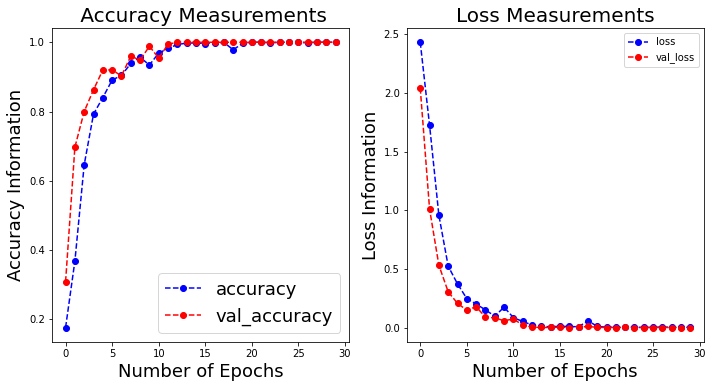

In [25]:
accuracy_and_loss_Plot(history1)

## Called VGG16 model

In [26]:
from tensorflow.keras.applications.vgg16 import VGG16
Vgg16=VGG16(weights="imagenet",include_top=False,input_shape=(image_size,image_size,3))

58900480/58889256 [==============================] - 0s 0us/step


In [27]:
model=Vgg16.output

model=tf.keras.layers.Dense (1024,activation='relu')(model)
model=tf.keras.layers.Dense (512,activation='relu')(model)
model=tf.keras.layers.GlobalAveragePooling2D()(model)
model=tf.keras.layers.Dense (256,activation='relu')(model)
model=tf.keras.layers.Dense (128,activation='relu')(model)
model=tf.keras.layers.Dropout(0.3)(model)
model=tf.keras.layers.Dense (11,activation="softmax")(model)
model=tf.keras.models.Model(inputs=Vgg16.input, outputs=model)

In [28]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [29]:
from tensorflow.keras.optimizers import SGD
optimizer = SGD(learning_rate = 1e-4, momentum = 0.9)

model.compile(loss='categorical_crossentropy',
             optimizer=optimizer,
              metrics=['accuracy']
             )

In [30]:
tensorboard=TensorBoard(log_dir="logs")
checkpoint=ModelCheckpoint("Vgg16.h5",
                          monitor='val_accuracy',
                          mode="auto",
                          verbose=1,
                          save_best_only=True
                          )

reduce_LR=ReduceLROnPlateau(monitor='val_accuracy',
                           factor=0.1,
                            patience=10,
                            min_delta=0.001,
                            mode="auto",
                            verbose=1
                           )

2022-11-04 03:46:13.665396: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-11-04 03:46:13.665450: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-11-04 03:46:14.016675: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-11-04 03:46:14.016869: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed


In [31]:
import timeit
start=timeit.default_timer()
history2=model.fit(xtrain,ytrain,
                 validation_split=0.1,
                  epochs=30,
                  verbose=1,
                  batch_size=32,
                  callbacks=[tensorboard, checkpoint,reduce_LR]
                 )
stop=timeit.default_timer()

Epoch 1/30
 1/49 [..............................] - ETA: 1:06 - loss: 4.2341 - accuracy: 0.1250

2022-11-04 03:46:18.320785: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-11-04 03:46:18.320848: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


 2/49 [>.............................] - ETA: 41s - loss: 4.0401 - accuracy: 0.0781 

2022-11-04 03:46:19.276379: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-11-04 03:46:19.276996: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2022-11-04 03:46:19.434924: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 445 callback api events and 442 activity events. 
2022-11-04 03:46:19.448719: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-11-04 03:46:19.461371: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/train/plugins/profile/2022_11_04_03_46_19

2022-11-04 03:46:19.472403: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_11_04_03_46_19/ecddcb1e852c.trace.json.gz
2022-11-04 03:46:19.493533: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/train/plug

49/49 [==============================] - 22s 439ms/step - loss: 2.3020 - accuracy: 0.2265 - val_loss: 1.5969 - val_accuracy: 0.5429

Epoch 00001: val_accuracy improved from -inf to 0.54286, saving model to Vgg16.h5
Epoch 2/30
49/49 [==============================] - 21s 436ms/step - loss: 1.1790 - accuracy: 0.5890 - val_loss: 0.5519 - val_accuracy: 0.8114

Epoch 00002: val_accuracy improved from 0.54286 to 0.81143, saving model to Vgg16.h5
Epoch 3/30
49/49 [==============================] - 22s 445ms/step - loss: 0.5455 - accuracy: 0.7964 - val_loss: 0.3079 - val_accuracy: 0.8971

Epoch 00003: val_accuracy improved from 0.81143 to 0.89714, saving model to Vgg16.h5
Epoch 4/30
49/49 [==============================] - 21s 436ms/step - loss: 0.3558 - accuracy: 0.8545 - val_loss: 0.2219 - val_accuracy: 0.8857

Epoch 00004: val_accuracy did not improve from 0.89714
Epoch 5/30
49/49 [==============================] - 21s 434ms/step - loss: 0.2268 - accuracy: 0.9068 - val_loss: 0.1441 - val_ac

In [32]:
print("Time: ",stop-start)

Time:  636.8997791509998


In [38]:
pred=model.predict(xtest)
score=model.evaluate(xtest,ytest)

7/7 [==============================] - 1s 100ms/step - loss: 7.1834e-04 - accuracy: 1.0000


In [39]:
pred=np.argmax(pred,axis=1)
ytest=np.argmax(ytest,axis=1)
print(classification_report(ytest,pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        22
           1       1.00      1.00      1.00        13
           2       1.00      1.00      1.00        21
           3       1.00      1.00      1.00        17
           4       1.00      1.00      1.00        19
           5       1.00      1.00      1.00        18
           6       1.00      1.00      1.00        15
           7       1.00      1.00      1.00        19
           8       1.00      1.00      1.00        12
           9       1.00      1.00      1.00        22
          10       1.00      1.00      1.00        16

    accuracy                           1.00       194
   macro avg       1.00      1.00      1.00       194
weighted avg       1.00      1.00      1.00       194



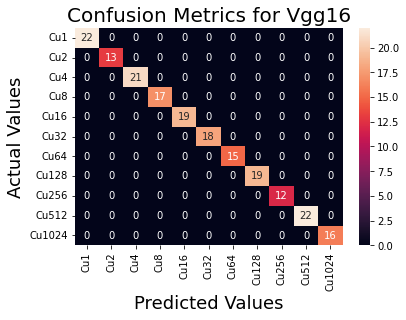

In [40]:
Cm=confusion_matrix(ytest,pred)
ax=plt.axes()
sns.heatmap(Cm, annot=True,
           annot_kws={'size':10},
           xticklabels=labels,
            yticklabels=labels,
            ax=ax
           )

plt.title("Confusion Metrics for Vgg16",fontsize=20)
plt.xlabel("Predicted Values", fontsize=18)
plt.ylabel("Actual Values",fontsize=18)
plt.show()

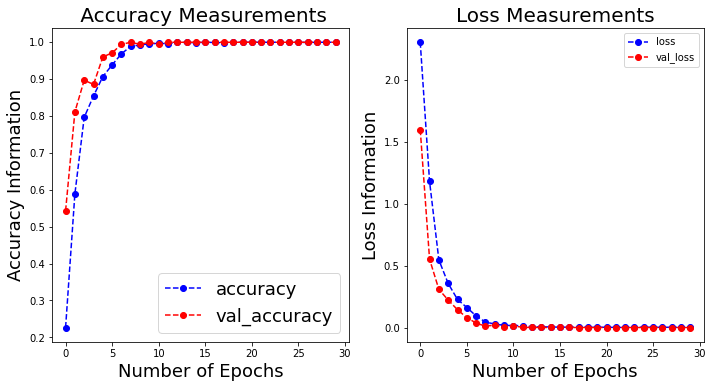

In [41]:
accuracy_and_loss_Plot(history2)

## Comparison between VGG16 and VGG19

## Training performance

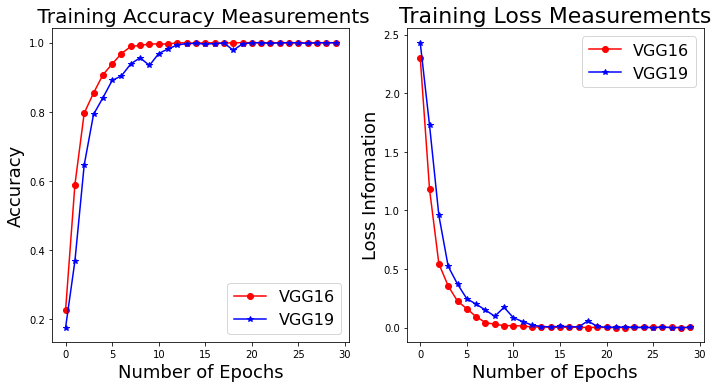

In [42]:
    fig=plt.figure(figsize=(10,10))
    
    plt.subplot(221)
    plt.plot(history2.history["accuracy"], 'ro-',history1.history["accuracy"], 'b*-', label='accuracy')
   
    plt.title(" Training Accuracy Measurements",fontsize=20)
    plt.xlabel("Number of Epochs",fontsize=18)
    plt.ylabel("Accuracy",fontsize=18)
    #plt.grid()
    plt.legend(['VGG16','VGG19'],fontsize=16)
    plt.tight_layout()
    
    plt.subplot(222)
    plt.plot( history2.history["loss"], 'ro-',history1.history["loss"], 'b*-',label='loss')
    plt.title("Training Loss Measurements",fontsize=22)
    plt.xlabel("Number of Epochs",fontsize=18)
    plt.ylabel("Loss Information",fontsize=18)
    #plt.grid()
    plt.legend(['VGG16','VGG19'],fontsize=16)
    plt.tight_layout()


## Validation performance

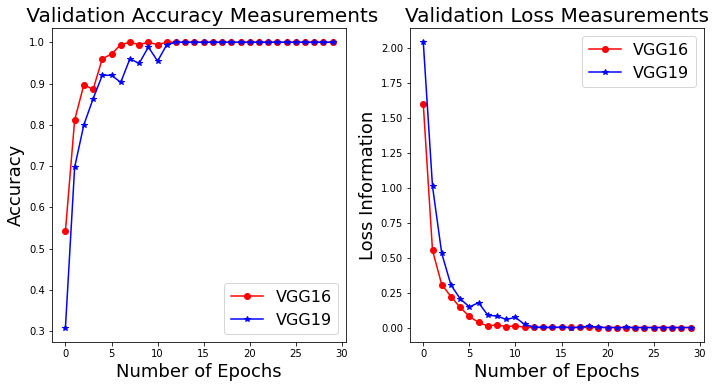

In [43]:
    fig=plt.figure(figsize=(10,10))
    
    plt.subplot(221)
    plt.plot( history2.history["val_accuracy"], 'ro-',history1.history["val_accuracy"], 'b*-', label='val_accuracy')
   
    plt.title(" Validation Accuracy Measurements",fontsize=20)
    plt.xlabel("Number of Epochs",fontsize=18)
    plt.ylabel("Accuracy",fontsize=18)
    #plt.grid()
    plt.legend(['VGG16','VGG19'],fontsize=16)
    plt.tight_layout()
    
    plt.subplot(222)
    plt.plot( history2.history["val_loss"], 'ro-',history1.history["val_loss"], 'b*-',label='val_loss')
    plt.title("Validation Loss Measurements",fontsize=20)
    plt.xlabel("Number of Epochs",fontsize=18)
    plt.ylabel("Loss Information",fontsize=18)
    #plt.grid()
    plt.legend(['VGG16','VGG19'],fontsize=16)
    plt.tight_layout()

## We see that VGG16 provides higher accuracy than VGG19 and Vgg16 has also less parameter than VGG19

In [44]:
def imagePrediction(upload):
    for name, fileinfo  in uploader.value.items():
        image = Image.open(io.BytesIO(fileinfo['content']))
        
    images = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
    images = cv2.resize(images,(150, 150))
    images = images.reshape(1, 150, 150, 3)
    prd = model.predict(images)
    prd = np.argmax(prd, axis = 1)[0]
    
    if prd == 0:
        prd = "Cu1"
    elif prd == 1:
        prd = "Cu2"
    elif prd ==2:
        prd = "Cu4"
        
    elif prd == 3:
        prd = "Cu8"
    elif prd ==4:
        prd = "Cu16"
    elif prd == 5:
        prd = "Cu32"
    elif prd ==6:
        prd = "Cu64"
    elif prd == 7:
        prd = "Cu128"
    elif prd ==8:
        prd = "Cu256"
    elif prd == 9:
        prd = "Cu512"
    elif prd ==10:
        prd = "Cu1024"
        
    print(f'Model Predict That is  a {prd}')
        

In [52]:
uploader = widgets.FileUpload()
display(uploader)

FileUpload(value={}, description='Upload')

In [51]:
button = widgets.Button(description= "Predict")
out = widgets.Output()

def on_button_click(_):
    with out:
        clear_output()
        try:
            imagePrediction(uploader)
        except:
            print("Please Enter the Correct Image files")
            
            
button.on_click(on_button_click)
widgets.VBox([button, out])

## save and Plot a model

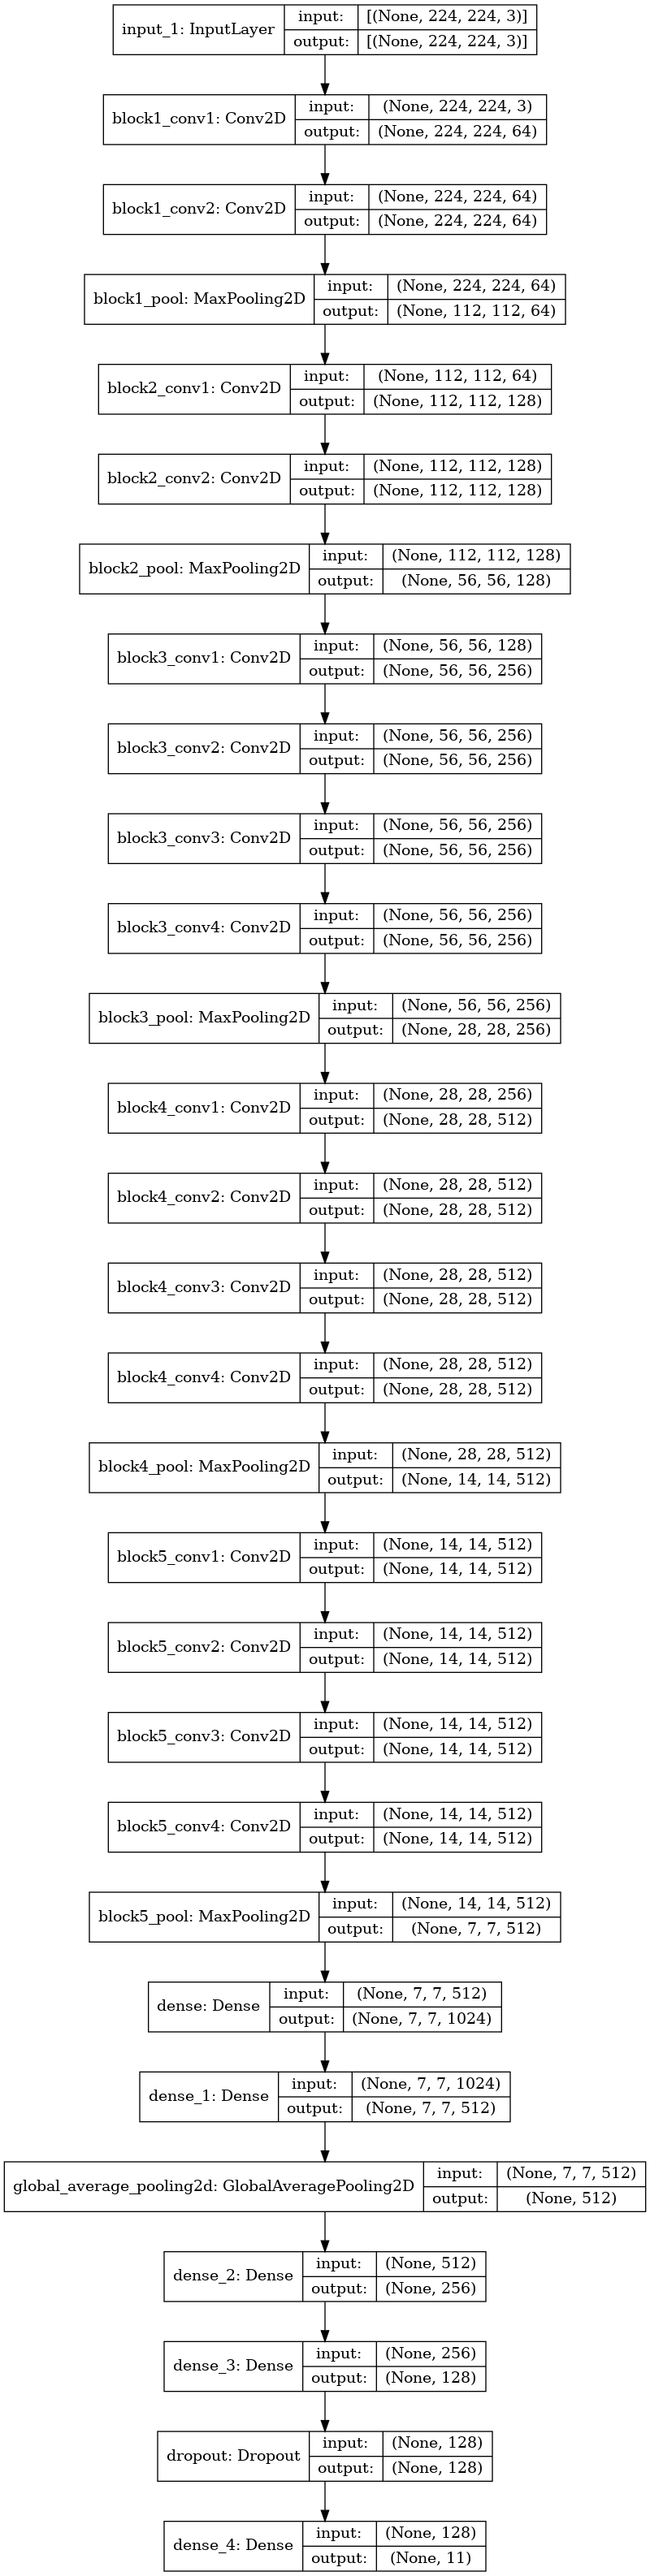

In [47]:

from keras.utils.vis_utils import plot_model

saved_model=tf.keras.models.load_model("./Vgg19.h5")

#show model architecture
plot_model(saved_model,
           to_file='./Vgg19.png',
           show_shapes=True,
           show_layer_names=True
          )

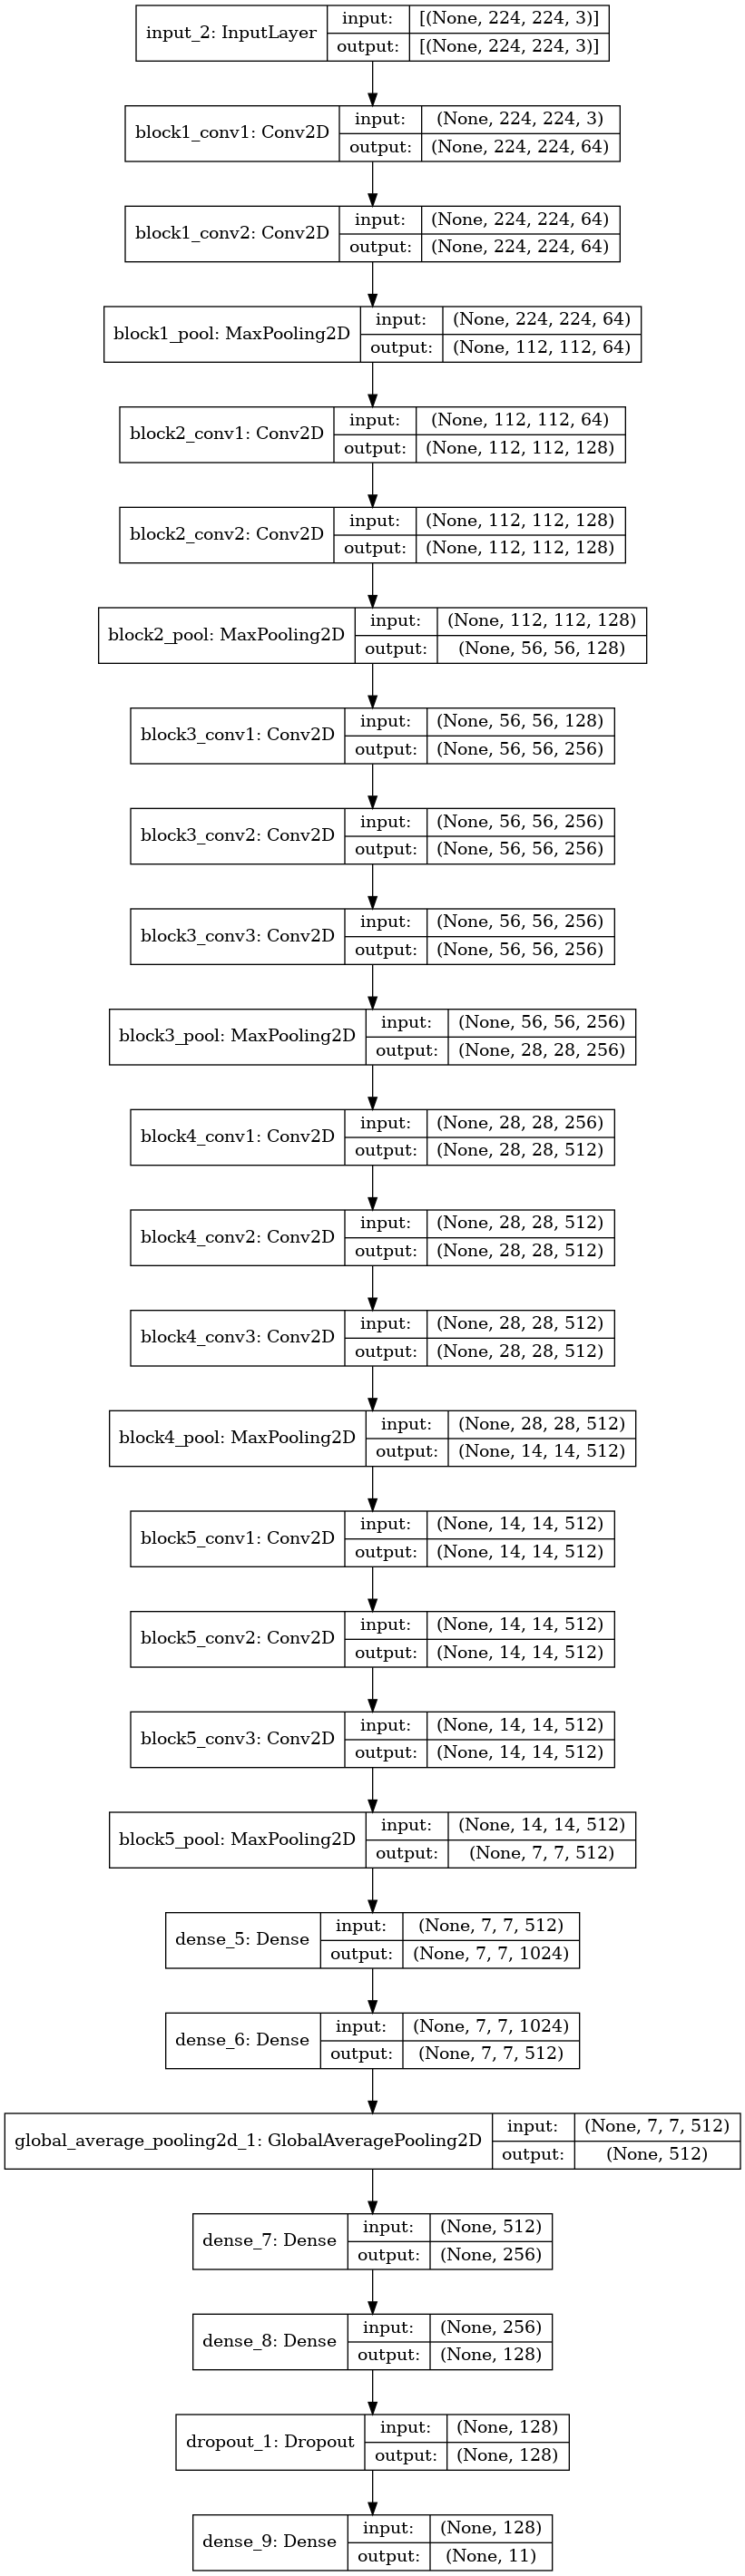

In [48]:
saved_model=tf.keras.models.load_model("./Vgg16.h5")

#show model architecture
plot_model(saved_model,
           to_file='./Vgg16.png',
           show_shapes=True,
           show_layer_names=True
          )

## Finally we said that, VGG16 is a good model for image-based classification problems.